In [7]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent) + '/mri_histology_toolkit')
sys.path.append(str(Path.cwd().parent.parent) + '/homologous_point_prediction')
sys.path.append(str(Path.cwd().parent))


# from homologous_point_prediction.evaluate import evaluate, evaluate_rotation

from mri_histology_toolkit.data_loader import DataLoader

import torch

import cv2

import click
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import numpy as np
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

import segm.utils.torch as ptu
import wandb

from segm.data.utils import STATS
from segm.data.ade20k import ADE20K_CATS_PATH
from segm.data.utils import dataset_cat_description, seg_to_rgb

from segm.model.factory import load_model
from segm.model.utils import inference

model_path = '/home/nelsonni/laviolette/segmenter/seg_tiny_mask_retrain/checkpoint.pth'
gpu = True
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data.distributed import DistributedSampler


import torch.nn.functional as Fu



In [2]:
from segm.unet.unet_model import UNet

In [19]:
x = ElasticTransform(alpha=2)


In [8]:
from segm.data_processing.seg_data_loader import SegDataLoader
from segm.data_processing.transforms import RandomCrop, RandomFlip, ElasticTransform, ToColor

In [26]:
augs = transforms.Compose([RandomCrop(400), RandomFlip(), ElasticTransform(alpha=2), ToColor()])

In [28]:
training_data_config = "/home/nelsonni/laviolette/method_analysis/configs/seg_train_config.json"
loader = SegDataLoader(training_data_config, transform=augs)

Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1104/MRI
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1105/MRI
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/10
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/11
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/12
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/13
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/5
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/6
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/7
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1107/8
'NoneType' object has no 

Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1158/13
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1158/15
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1158/MRI
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1159/12
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1159/13
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1159/14
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1159/MRI
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1185/MRI
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1187/12
'NoneType' object has no attribute 'shape'
Skipping /data/ur/bukowy/LaViolette_Data/Prostates/1187/13
'NoneType' object ha

In [29]:
dataloader = DataLoader(loader, batch_size=16,
                        shuffle=True)

In [6]:
for batch in dataloader:
#     plt.imshow(batch['mri'][0])
    print(batch['mri'].shape)
#     break

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([15, 3, 512, 512])


In [44]:
img = loader[9]

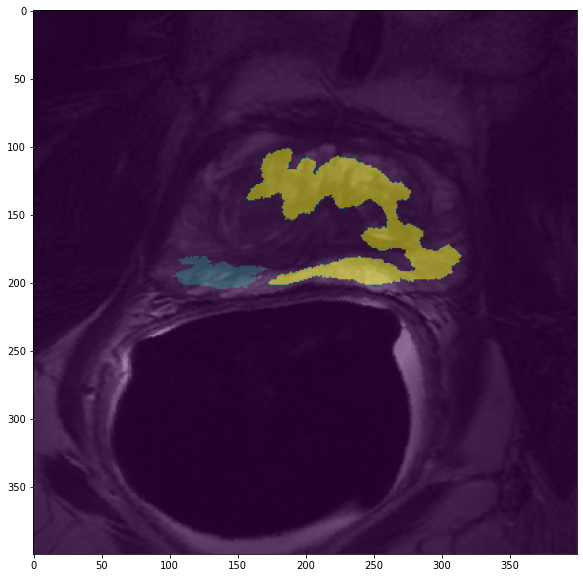

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(img['mri'].permute(1,2,0))
plt.imshow(img['seg'], alpha=.5)

In [71]:
np.unique(img['seg'])

array([0., 2., 6.], dtype=float32)

In [8]:
u = UNet(n_channels=3, n_classes=8)

In [ ]:
mri_t = x(img)
plt.figure(figsize=(10,10))

# im = mri_t['mri'].permute(1, 2, 0)
plt.imshow(mri_t['mri'])
plt.imshow(mri_t['seg'], alpha=.5)

In [ ]:
ptu.set_gpu_mode(gpu)

model_dir = Path(model_path).parent
model, variant = load_model(model_path)
model.to(ptu.device)

normalization_name = variant["dataset_kwargs"]["normalization"]
normalization = STATS[normalization_name]
# cat_names, cat_colors = dataset_cat_description(ADE20K_CATS_PATH)
cat_names = ['background',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7'
            ]
cat_colors = {
    0: torch.tensor([0.0, 0.0, 0.0]).float(), 
    1: torch.tensor([255.0, 51.0, 51.0]).float() / 255.0, # red
    2: torch.tensor([255.0, 255.0, 255.0]).float() / 255.0, # orange
    3: torch.tensor([255.0, 255.0, 0.0]).float() / 255.0, # yellow
    4: torch.tensor([0.0, 255.0, 0.0]).float() / 255.0, # green
    5: torch.tensor([0.0, 255.0, 255.0]).float() / 255.0, # cyan
    6: torch.tensor([0.0, 0.0, 255.0]).float() / 255.0, # blue
    7: torch.tensor([255.0, 0.0, 255.0]).float() / 255.0, # pink
}

# input_dir = Path(input_dir)
# output_dir = Path(output_dir)
# output_dir.mkdir(exist_ok=True)

In [ ]:
input_dir = Path('/home/nelsonni/laviolette/segmenter/ade20k/ade20k/release_test/testing/')

list_dir = list(input_dir.iterdir())
for filename in tqdm(list_dir, ncols=80):
    pil_im = Image.open(filename).copy()
    im = F.pil_to_tensor(pil_im).float() / 255
    print(im.shape)
    print(normalization["std"])
    im = F.normalize(im, normalization["mean"], normalization["std"])
    im = im.to(ptu.device).unsqueeze(0)

    im_meta = dict(flip=False)
    logits = inference(
        model,
        [im],
        [im_meta],
        ori_shape=im.shape[2:4],
        window_size=variant["inference_kwargs"]["window_size"],
        window_stride=variant["inference_kwargs"]["window_stride"],
        batch_size=2,
    )
    seg_map = logits.argmax(0, keepdim=True)
    seg_rgb = seg_to_rgb(seg_map, cat_colors)
    seg_rgb = (255 * seg_rgb.cpu().numpy()).astype(np.uint8)
    pil_seg = Image.fromarray(seg_rgb[0])

    pil_blend = Image.blend(pil_im, pil_seg, 0.5).convert("RGB")
#     pil_blend.save(output_dir / filename.name)

#     save_name = str(output_dir) + "/" + "original_" + str(filename.name)

#     pil_im.save(save_name)

In [ ]:
data_loader = DataLoader(config_path="/home/nelsonni/laviolette/method_analysis/configs/test_config.json")
for data_dict in data_loader:
    # if True:
    #     print(data_dict["patient"], data_dict["slide"])
    #     print(len(data_dict["hist_points"]))
    #     print(len(data_dict["mri_points"]))

    unmasked_mri = data_dict["unmasked_mri"]
    

    unmasked_mri = cv2.cvtColor(unmasked_mri, cv2.COLOR_GRAY2RGB)

    im = torch.from_numpy(unmasked_mri)
#     im = im.unsqueeze(0)
    im = im.permute(2, 0, 1)
    im = F.normalize(im, 0.5, 0.5)
    
    norm_image = cv2.normalize(unmasked_mri, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#     norm_image = torch.from_numpy(norm_image)
#     norm_image = norm_image.permute(2, 0, 1)

    im = im.to(ptu.device)

    im_meta = dict(flip=False)
    logits = inference(
        model,
        [im],
        [im_meta],
        ori_shape=im.shape[1:3],
        window_size=variant["inference_kwargs"]["window_size"],
        window_stride=variant["inference_kwargs"]["window_stride"],
        batch_size=2,
    )
    seg_map = logits.argmax(0, keepdim=True)
    seg_rgb = seg_to_rgb(seg_map, cat_colors)
    seg_rgb = (255 * seg_rgb.cpu().numpy()).astype(np.uint8)
    pil_seg = Image.fromarray(seg_rgb[0])

    file_name = data_dict['patient'] +'_' + data_dict['slide'] + '.jpg'
    pil_im = Image.fromarray(np.uint8(norm_image))
    

    pil_blend = Image.blend(pil_im, pil_seg, 0.3).convert("RGB")
#     pil_blend.save(output_dir / file_name)
    pil_blend.show()